In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
V = np.array([15,25,35,45])
Vc = np.cumsum(V)
max_B = 10000 # maximum budget
no_runs = 100 # no. of runs to average
K = 20 # controls number of restarts
T = Vc[-1] # Total nodes - 1

In [3]:
G = nx.Graph()

total = 0
for i in range(len(V)):
    #H = nx.complete_graph(range(total,total+V[i]))
    H = nx.gnp_random_graph(V[i],0.85)
    H = nx.convert_node_labels_to_integers(H, first_label=total, ordering='default', label_attribute=None)
    G = nx.compose(H,G)
    total+= V[i]

In [4]:
G.add_edges_from([(0,Vc[-1]),(Vc[0],Vc[-1]),(Vc[1],Vc[-1]),(Vc[2],Vc[-1])])
G_no_edges=G.number_of_edges()
G_no_nodes=G.number_of_nodes()
print(G_no_nodes,G_no_edges)

121 1705


/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/home/sc/anaconda3/envs/old_nx/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:


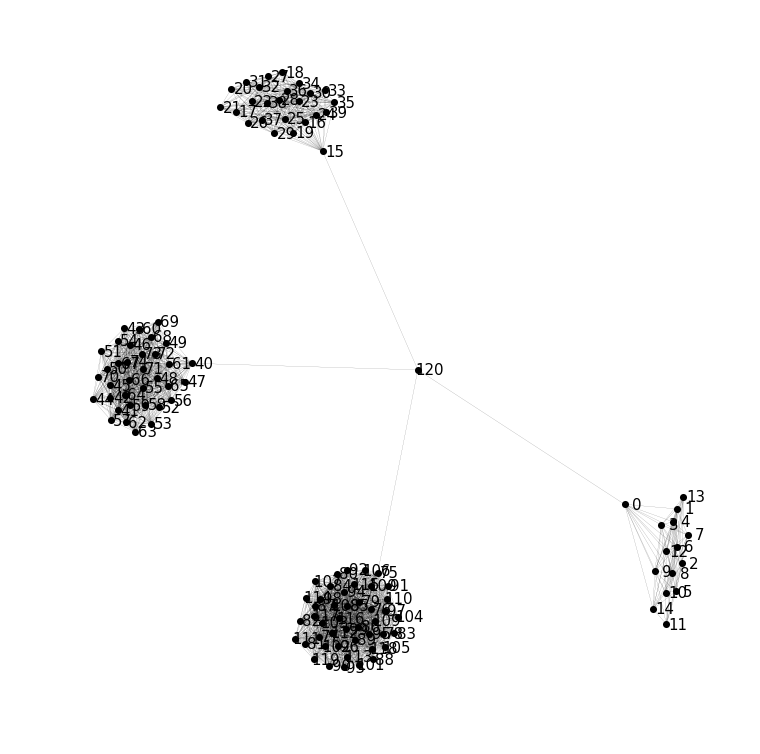

In [5]:
options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
}
'''
nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
for x in range(len(pos)):
    pos[x] = pos[x]+np.array([0.02,0])
labels = dict([(n, n) for n in G.nodes()]) #add labels
_ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels
'''

plt.figure(1,figsize=(10,10)) 
pos = nx.spring_layout(G)  # Seed for reproducible layout
nx.draw(G, pos, **options)
for x in range(len(pos)):
    pos[x] = pos[x]+np.array([0.02,0])
labels = dict([(n, n) for n in G.nodes()]) #add labels
_ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels
plt.show()

Modularity for best partition: 0.6389140100274041


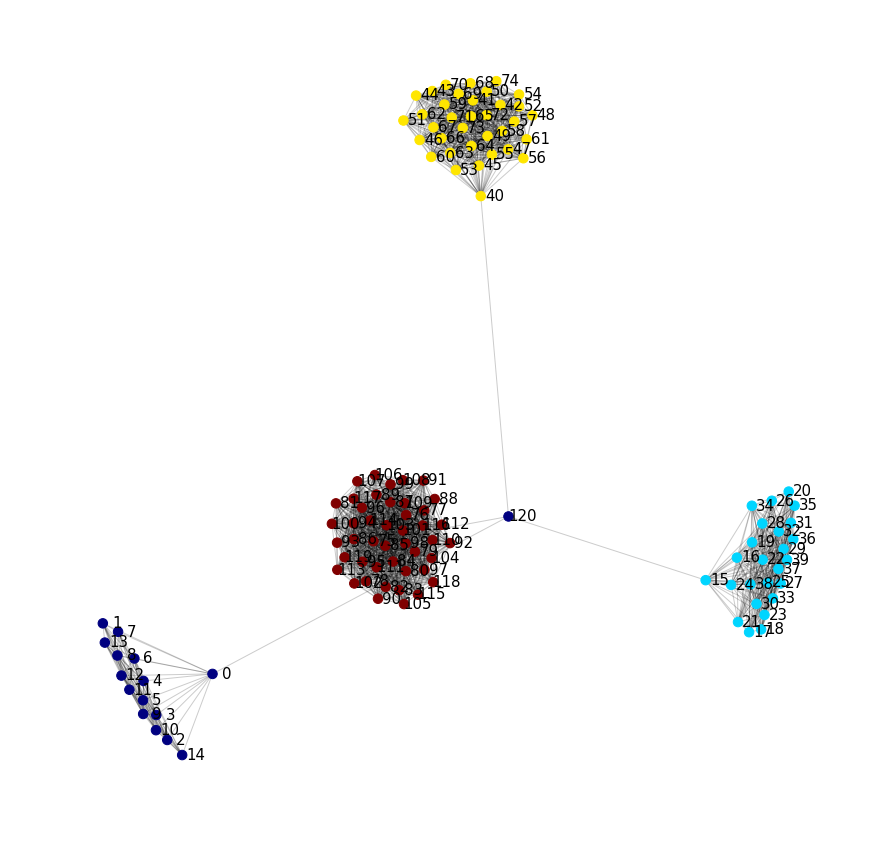

In [12]:
from louvain import detect_communities, modularity
def draw_communities(G, node_size=90, alpha=1, k=None, randomized=False):
    partition = detect_communities(G, randomized=randomized)
    print("Modularity for best partition:", modularity(G, partition))
    community_map = {}
    for community, nodes in enumerate(partition):
        for node in nodes:
            community_map[node] = community
    
    cmap = plt.get_cmap("jet")
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(G, k=k)
    indexed = [community_map.get(node) for node in G]
    plt.axis("off")
    nx.draw_networkx_nodes(G, pos=pos, cmap=cmap, node_color=indexed, node_size=node_size, alpha=alpha)
    nx.draw_networkx_edges(G, pos=pos, alpha=0.2)
    for x in range(len(pos)):
        pos[x] = pos[x]+np.array([0.02,0])
    labels = dict([(n, n) for n in G.nodes()]) #add labels
    _ = nx.draw_networkx_labels(G, pos, labels=labels, font_color='#000000', font_size=15) #draw labels
draw_communities(G)

In [13]:
partition = detect_communities(G, randomized=False)
community_map = {}
node_map = {}

In [14]:
for community, nodes in enumerate(partition):
    for node in nodes:
        node_map[node] = community
    community_map[community] = nodes
print(len(community_map))

4


In [15]:
for i in range(4):
    if T in community_map[i]:
        community_map[i].remove(T)

In [16]:
node_map[T] = 4

In [17]:
def node_fn(node):
    return int(node_map[node]==1)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.2066115702479339


In [23]:
def MH_sampling(G,B):
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample_t = np.random.choice(neighbors)
        if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
            sample = sample_t
        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

def RDS_sampling(G,B):
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        neighbors = list(nx.neighbors(G,sample))
        sample = np.random.choice(neighbors)
        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

In [24]:
def RDSRR_sampling(G,B,U=None):
    #M = np.power(B,2/3)
    #restart_ind = np.power(np.arange(1,M),1.5)
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(K*np.log(t)))
        t+=1
    
    est_RW = []
    est_RW_t1 = 0
    est_RW_t2 = 0
    sample = np.random.choice(G.nodes())
    deg_pr_sent = G.degree(sample)
    est_RW_t1 += node_fn(sample)/deg_pr_sent
    est_RW_t2 += 1/deg_pr_sent
    est_RW.append(est_RW_t1/est_RW_t2)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample = np.random.choice(neighbors)

        deg_pr_sent = G.degree(sample)
        est_RW_t1 += node_fn(sample)/deg_pr_sent
        est_RW_t2 += 1/deg_pr_sent
        est_RW.append(est_RW_t1/est_RW_t2)
    return np.array(est_RW)

def MHRR_sampling(G,B,U=None):
    #M = np.power(B,2/3)
    #restart_ind = np.power(np.arange(1,M),1.5)
    restart_ind = [10]
    t=20
    while restart_ind[-1]<B:
        restart_ind.append(restart_ind[-1]+int(K*np.log(t)))
        t+=1
    
    est_MH= []
    est_MH_t = 0
    sample = np.random.choice(G.nodes())
    est_MH_t += node_fn(sample)
    est_MH.append(est_MH_t)
    for ii in range(2,B+1):
        if ii in restart_ind:
            #sample_t = np.random.choice(community_map[np.random.randint(len(community_map))])
            if U is None:
                sample = np.random.choice(community_map[np.random.choice([x for x in list(community_map.keys()) if x!=node_map[sample]])])
            else:
                z = [node_map[x] for x in U].index(node_map[sample])
                sample = np.random.choice(U[:z]+U[z+1:])
        else:
            neighbors = list(nx.neighbors(G,sample))
            sample_t = np.random.choice(neighbors)
            if np.random.rand() <= (G.degree(sample)/G.degree(sample_t)):
                sample = sample_t

        est_MH_t += node_fn(sample)
        est_MH.append(est_MH_t/ii)
    return np.array(est_MH)

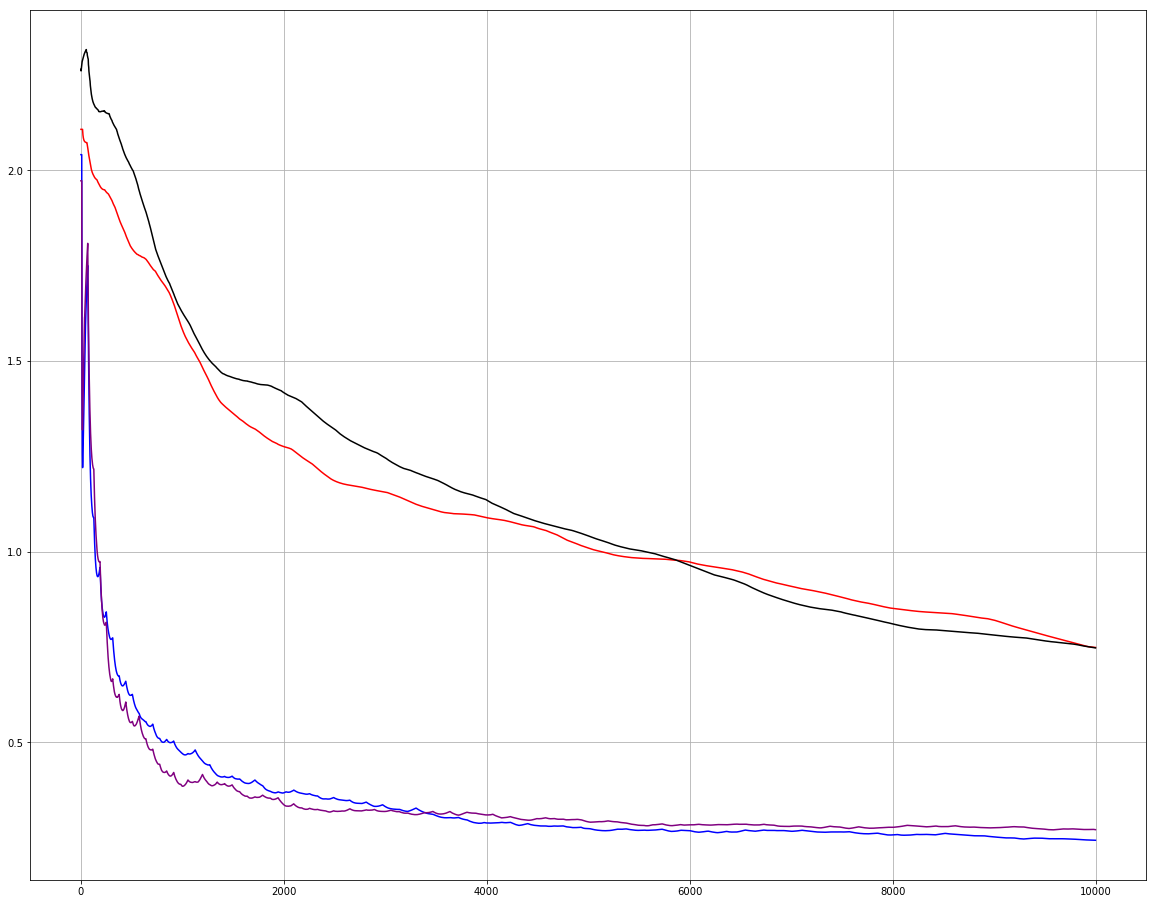

In [25]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(3,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5)
plt.grid()

In [26]:
def node_fn(node):
    return int(G.degree(node)>25)
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.6528925619834711


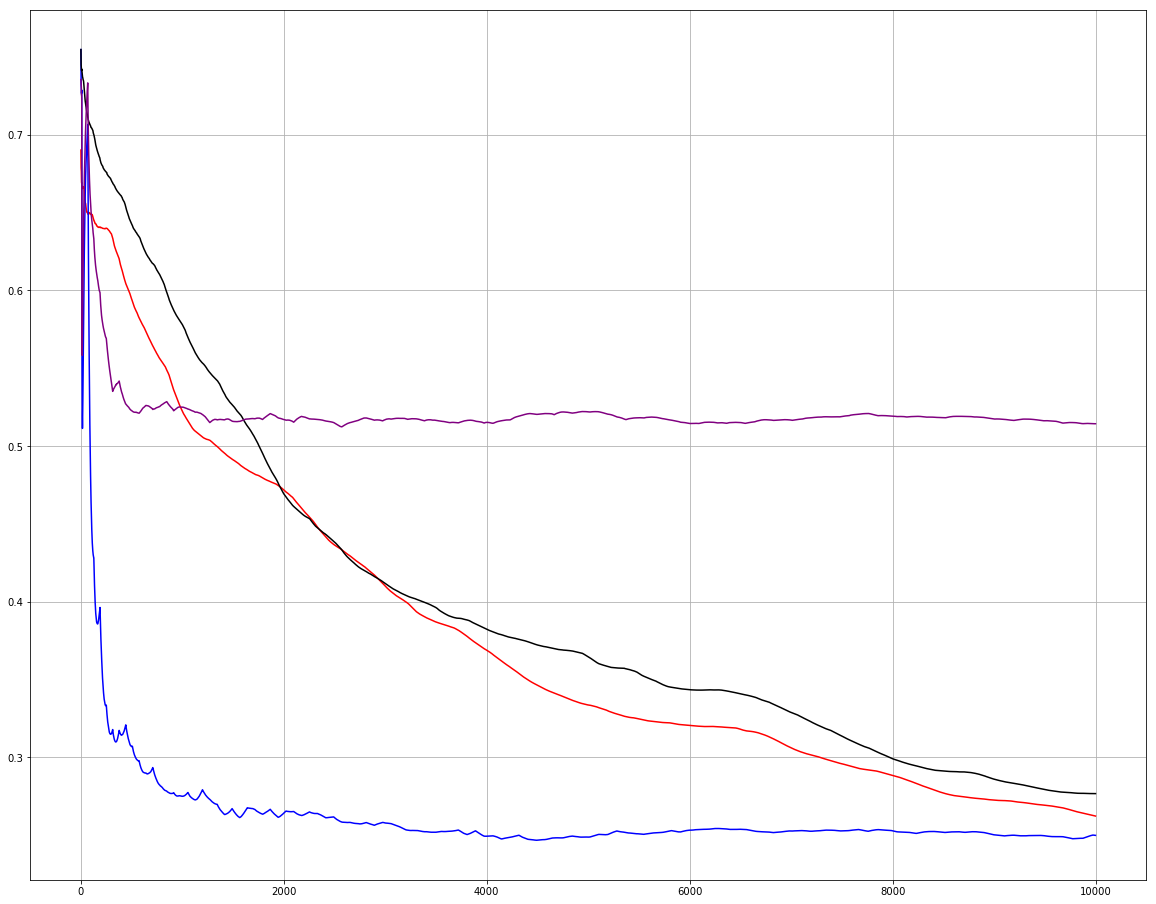

In [27]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(4,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5)
plt.grid()

In [22]:
def node_fn(node):
    deg = G.degree(node)
    if deg < 2:
        return 0
    else:
        return 2*nx.triangles(G,node)/(deg*(deg-1))
F_org = sum([node_fn(i) for i in G.nodes()])/G_no_nodes
print(F_org)

0.8306870892215511


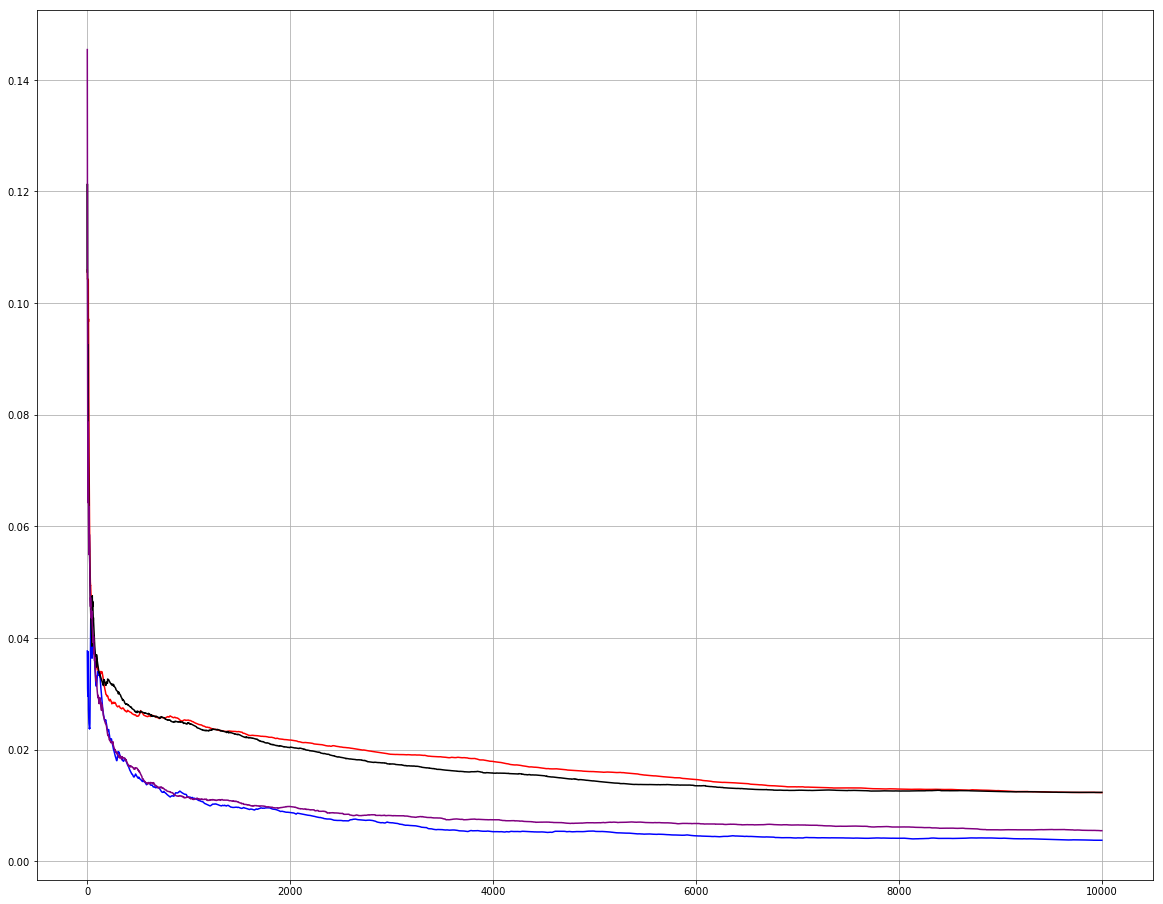

In [23]:
MSE_MH_t = 0
for ii in range(1,no_runs+1):
    MSE_MH_t += (MH_sampling(G,max_B)-F_org)**2
MSE_MH = MSE_MH_t/(no_runs)
MSE_MH = np.sqrt(MSE_MH)/F_org

MSE_rds_t = 0
for ii in range(1,no_runs+1):
    MSE_rds_t += (RDS_sampling(G,max_B)-F_org)**2
MSE_rds = MSE_rds_t/(no_runs)
MSE_rds = np.sqrt(MSE_rds)/F_org

MSE_rdsrr_t = 0
for ii in range(1,no_runs+1):
    MSE_rdsrr_t += (RDSRR_sampling(G,max_B)-F_org)**2
MSE_rdsrr = MSE_rdsrr_t/(no_runs)
MSE_rdsrr = np.sqrt(MSE_rdsrr)/F_org

MSE_mhrr_t = 0
for ii in range(1,no_runs+1):
    MSE_mhrr_t += (MHRR_sampling(G,max_B)-F_org)**2
MSE_mhrr = MSE_mhrr_t/(no_runs)
MSE_mhrr = np.sqrt(MSE_mhrr)/F_org


plt.figure(5,figsize=(20,16)) 
plt.plot(np.array(list(range(len(MSE_MH)))),MSE_MH,color='red',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_mhrr)))),MSE_mhrr,color='blue',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rds)))),MSE_rds,color='black',linewidth=1.5)
plt.plot(np.array(list(range(len(MSE_rdsrr)))),MSE_rdsrr,color='purple',linewidth=1.5)
plt.grid()